In [ ]:
!pip install scikit-learn
!pip install torchvision

In [8]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              transforms.Lambda(lambda x: torch.flatten(x))])

train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train= len(train_set)//5
batch_size_test=len(test_set)

In [3]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [2]:
def evaluate_models(models):
    results_short = {}
    for score in scores:
        print('='*40)
        print("# Tuning hyper-parameters for %s" % score)
        print()

        for m in model_lbls:
            print('-'*40)
            print("Trying model {}".format(models[m]['name']))
            clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                               scoring='%s_macro' % score, 
                               return_train_score = False,
                               n_jobs = -1, 
                               )
            clf.fit(train_x, train_y)
            print_results(clf)
            results_short[m] = clf.best_score_
        print("Summary of results for {}".format(score))
        print("Estimator")
        for m in results_short.keys():
            print("{}\t - score: {:4.2}%".format(models[m]['name'], results_short[m]))

def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    print("Mean test score: {}".format(means))
    print("Std test score: {}".format(stds))
    print("Params test score: {}".format(params))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    true_y, pred_y = test_y, model.predict(test_x)
    print(classification_report(true_y, pred_y))
    print()
    
def plot_scores_by_parameter(model,ks,X_train,X_test,y_train,y_test,visualize=True):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = model(k).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.plot(ks, train_scores, color='blue', label='train score')
        plt.plot(ks, test_scores, color='green', label='test score')
        plt.legend()
    return train_scores,test_scores

## Multi-layer Perceptron

In [3]:
from sklearn.neural_network import MLPClassifier

### Single hidden layer

In [7]:
model_lbls = ['mp']

models = {
    'mp': {'name': 'Multi-layer Perceptron Classifier       ',
           'estimator': MLPClassifier(random_state=0), 
           'param': [{'hidden_layer_sizes': [(500), (200), (100), (50)]}],
          },
}

model_lbls = ['mp']
scores = ['f1']

evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Multi-layer Perceptron Classifier       
Best parameters set found on train set:

{'hidden_layer_sizes': 500}

Grid scores on train set:

Mean test score: [0.87074679 0.86400664 0.86118058 0.84918392]
Std test score: [0.00538104 0.00347564 0.00586011 0.00547648]
Params test score: [{'hidden_layer_sizes': 500}, {'hidden_layer_sizes': 200}, {'hidden_layer_sizes': 100}, {'hidden_layer_sizes': 50}]

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1000
           1       0.98      0.97      0.98      1000
           2       0.77      0.79      0.78      1000
           3       0.83      0.91      0.87      1000
           4       0.81      0.76      0.79      1000
           5       0.98      0.87    

We will try to find the best activation function for the hidden layer

In [8]:
model_lbls = ['mp']

models = {
    'mp': {'name': 'Multi-layer Perceptron Classifier       ',
           'estimator': MLPClassifier(random_state=0, hidden_layer_sizes=(500)), 
           'param': [{'activation':['identity', 'logistic', 'tanh', 'relu']}],
          },
}

model_lbls = ['mp']
scores = ['f1']

evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Multi-layer Perceptron Classifier       
Best parameters set found on train set:

{'activation': 'relu'}

Grid scores on train set:

Mean test score: [0.81822396 0.86479294 0.86251006 0.87074679]
Std test score: [0.00982759 0.00475728 0.00272013 0.00538104]
Params test score: [{'activation': 'identity'}, {'activation': 'logistic'}, {'activation': 'tanh'}, {'activation': 'relu'}]

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1000
           1       0.98      0.97      0.98      1000
           2       0.77      0.79      0.78      1000
           3       0.83      0.91      0.87      1000
           4       0.81      0.76      0.79      1000
           5       0.98      0.87      0.92      1000

The default activation - rectified linear unit function seems to be optimal.
Testing different regularization strength:

In [9]:
model_lbls = ['mp']

models = {
    'mp': {'name': 'Multi-layer Perceptron Classifier       ',
           'estimator': MLPClassifier(random_state=0, hidden_layer_sizes=(500), verbose=False), 
           'param': [{'alpha':[0.00001, 0.0001, 0.001, 0.01]}],
          },
}

model_lbls = ['mp']
scores = ['f1']

evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Multi-layer Perceptron Classifier       
Iteration 1, loss = 0.76870678
Iteration 2, loss = 0.48272789
Iteration 3, loss = 0.43736476
Iteration 4, loss = 0.39921654
Iteration 5, loss = 0.36654638
Iteration 6, loss = 0.35716572
Iteration 7, loss = 0.33994561
Iteration 8, loss = 0.32149088
Iteration 9, loss = 0.30161304
Iteration 10, loss = 0.31197904
Iteration 11, loss = 0.27822737
Iteration 12, loss = 0.26940289
Iteration 13, loss = 0.26202919
Iteration 14, loss = 0.24874819
Iteration 15, loss = 0.24139113
Iteration 16, loss = 0.24249691
Iteration 17, loss = 0.21992352
Iteration 18, loss = 0.21296530
Iteration 19, loss = 0.20668017
Iteration 20, loss = 0.20382384
Iteration 21, loss = 0.18779216
Iteration 22, loss = 0.19476406
Iteration 23, loss = 0.17791156
Iteration 24, loss = 0.17846975
Iteration 25, loss = 0.17099973
Iteration 26, loss = 0.16271505
Iteration 27, loss = 0.15621008
Iteration 28, lo

Alpha = 0.001 seems to be the best.
More precise search:

In [10]:
model_lbls = ['mp']

models = {
    'mp': {'name': 'Multi-layer Perceptron Classifier       ',
           'estimator': MLPClassifier(random_state=0, hidden_layer_sizes=(500)), 
           'param': [{'alpha':[0.0005, 0.0007, 0.002, 0.003]}],
          },
}

model_lbls = ['mp']
scores = ['f1']

evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Multi-layer Perceptron Classifier       
Best parameters set found on train set:

{'alpha': 0.0005}

Grid scores on train set:

Mean test score: [0.87273174 0.87216315 0.87101454 0.87268277]
Std test score: [0.00468255 0.00557654 0.00174476 0.00579765]
Params test score: [{'alpha': 0.0005}, {'alpha': 0.0007}, {'alpha': 0.002}, {'alpha': 0.003}]

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.98      0.97      0.98      1000
           2       0.77      0.79      0.78      1000
           3       0.89      0.87      0.88      1000
           4       0.78      0.80      0.79      1000
           5       0.95      0.93      0.94      1000
           6       0.69      0.67 

The more detailed search with alpha close to 0.001 gave worse results.We will stick with alpha = 0.001

### Testing on all the train data

In [5]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              transforms.Lambda(lambda x: torch.flatten(x))])

train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train= len(train_set)
batch_size_test=len(test_set)
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [5]:
mlp = MLPClassifier(random_state=0, alpha=0.001, hidden_layer_sizes=(500))

mlp.fit(train_x, train_y)
true_y, pred_y = test_y, mlp.predict(test_x)
print(classification_report(true_y, pred_y))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.82      0.82      0.82      1000
           3       0.91      0.90      0.90      1000
           4       0.82      0.84      0.83      1000
           5       0.98      0.97      0.98      1000
           6       0.74      0.74      0.74      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Second hidden layer

In [7]:
model_lbls = ['mp']

models = {
    'mp': {'name': 'Multi-layer Perceptron Classifier       ',
           'estimator': MLPClassifier(random_state=0, alpha=0.001), 
           'param': [{'hidden_layer_sizes':[(500, 500), (500, 300), (500, 200), (500, 100)]}],
          },
}
0
model_lbls = ['mp']
scores = ['f1']

evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Multi-layer Perceptron Classifier       
Best parameters set found on train set:

{'hidden_layer_sizes': (500, 300)}

Grid scores on train set:

Mean test score: [0.8736102  0.87558772 0.86897231 0.87256248]
Std test score: [0.00683737 0.01032117 0.00216618 0.00868897]
Params test score: [{'hidden_layer_sizes': (500, 500)}, {'hidden_layer_sizes': (500, 300)}, {'hidden_layer_sizes': (500, 200)}, {'hidden_layer_sizes': (500, 100)}]

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1000
           1       0.97      0.97      0.97      1000
           2       0.73      0.82      0.77      1000
           3       0.87      0.87      0.87      1000
           4       0.78      0.78      0.78      1000
 

Testing different combinations between neurons count:

In [8]:
model_lbls = ['mp']

models = {
    'mp': {'name': 'Multi-layer Perceptron Classifier       ',
           'estimator': MLPClassifier(random_state=0, alpha=0.001), 
           'param': [{'hidden_layer_sizes':[(600, 300), (768, 200), (400, 300), (500, 50), (300, 30)]}],
          },
}

model_lbls = ['mp']
scores = ['f1']

evaluate_models(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Multi-layer Perceptron Classifier       
Best parameters set found on train set:

{'hidden_layer_sizes': (500, 50)}

Grid scores on train set:

Mean test score: [0.86977518 0.8721577  0.87049862 0.8754242  0.87203675]
Std test score: [0.0048808  0.00782659 0.00824288 0.00338346 0.00336529]
Params test score: [{'hidden_layer_sizes': (600, 300)}, {'hidden_layer_sizes': (768, 200)}, {'hidden_layer_sizes': (400, 300)}, {'hidden_layer_sizes': (500, 50)}, {'hidden_layer_sizes': (300, 30)}]

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1000
           1       0.98      0.96      0.97      1000
           2       0.74      0.79      0.77      1000
           3       0.86      0.87      0.87      1000


It looks like 500 for the first layer is optimal. We got simmilar results with second layer 300 and 50, but worse with second layer 200 or 100.

### All data test for (500, 300)

In [4]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              transforms.Lambda(lambda x: torch.flatten(x))])

train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train= len(train_set)
batch_size_test=len(test_set)
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [7]:
mlp = MLPClassifier(random_state=0, alpha=0.001, hidden_layer_sizes=(500, 300))

mlp.fit(train_x, train_y)
true_y, pred_y = test_y, mlp.predict(test_x)
print(classification_report(true_y, pred_y))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.83      0.83      0.83      1000
           3       0.88      0.92      0.90      1000
           4       0.81      0.84      0.82      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.73      0.73      1000
           7       0.93      0.98      0.95      1000
           8       0.98      0.97      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, random_state=0)

model = MLPClassifier(random_state=0, alpha=0.001, hidden_layer_sizes=(500, 300)).fit(X_train, y_train)

In [12]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_valid, y_valid)

data = {'MLP 500-300':  ['Train score', 'Test score'],
        'Accuracy': [train_score ,test_score],
        }

df = pd.DataFrame(data)
print(df)

   MLP 500-300  Accuracy
0  Train score  0.996889
1   Test score  0.900933


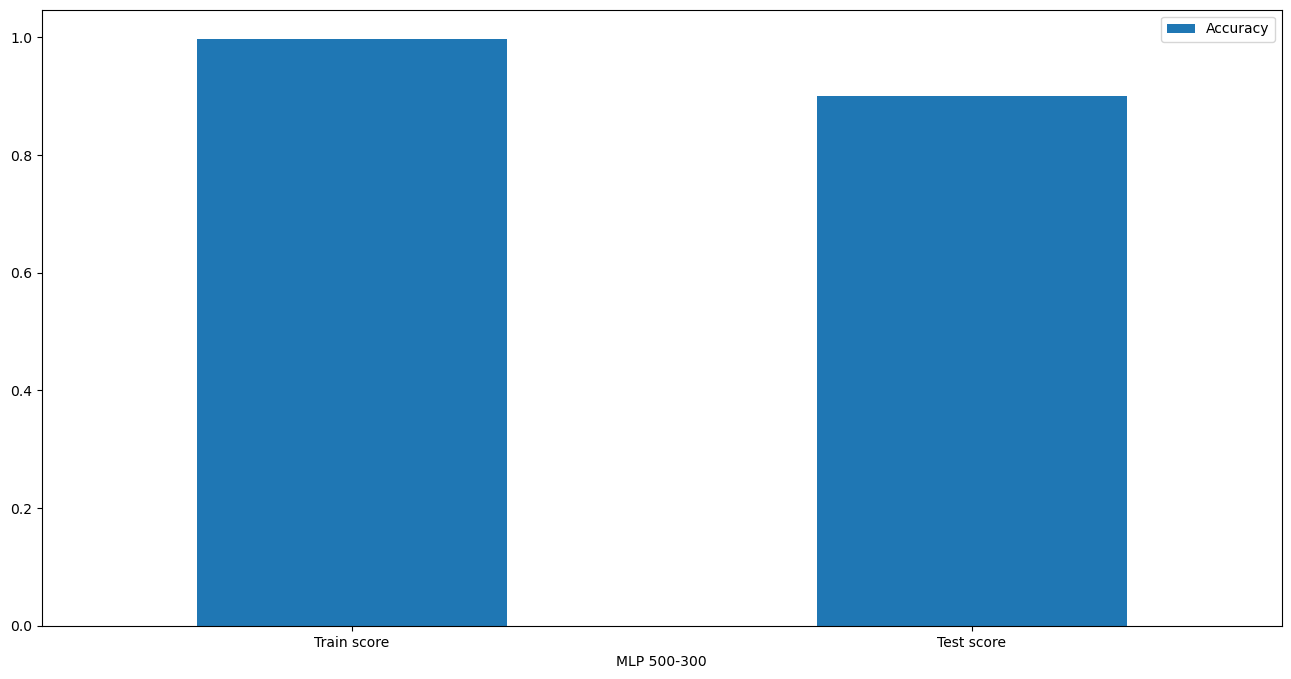

In [13]:
barplot = df.plot.bar(x='MLP 500-300', y='Accuracy', rot=0, figsize=(16,8))

### Third hidden layer

It seems that we start to overfit because the train results are better than the test. We will try 500-300-50.

In [9]:
mlp = MLPClassifier(random_state=0, alpha=0.001, hidden_layer_sizes=(500, 300, 50))

mlp.fit(train_x, train_y)
true_y, pred_y = test_y, mlp.predict(test_x)
print(classification_report(true_y, pred_y))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1000
           1       0.99      0.97      0.98      1000
           2       0.77      0.77      0.77      1000
           3       0.89      0.87      0.88      1000
           4       0.79      0.77      0.78      1000
           5       0.96      0.93      0.94      1000
           6       0.63      0.72      0.67      1000
           7       0.93      0.94      0.93      1000
           8       0.98      0.94      0.96      1000
           9       0.93      0.96      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.87     10000
weighted avg       0.87      0.86      0.87     10000



Overall the model with the second layer starts to overfit and adding third layer does not improve the situation